<a href="https://colab.research.google.com/github/KaufmanDmitriy/Repetit/blob/main/repetit_kaufman_dmitriy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

Выполнил Кауфман Дмитрий

Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

**Задачи:**

Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет производиться с использованием precision и ROC-AUC.

## Установка и импорт библиотек

In [ ]:
!pip install catboost optuna pymystem3 nltk

In [ ]:
from catboost import CatBoostClassifier
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from pymystem3 import Mystem
import re
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    cross_validate)
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score)

pd.set_option('display.max_columns', None)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

## Изучение данных

### Таблица ORDERS

In [ ]:
orders = pd.read_feather('/kaggle/input/repetit/data/orders.feather')

In [ ]:
orders.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


In [ ]:
orders_columns_drop = ['start_date', 'comments', 'estimated_fee',
                       'first_lesson_date', 'lesson_place', 'working_teacher_id',
                       'additional_status_id', 'prefered_teacher_id',
                       'payment_date', 'amount_to_pay',
                       'max_metro_distance', 'creator_id']
orders = orders.drop(orders_columns_drop, axis=1)

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 26 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   home_metro_id            642447 non-null   float32
 7   add_info                 1044688 non-null  object 
 8   status_id                1191861 non-null  int32  
 9   planned_lesson_number    1191861 non-null  int32  
 10  pupil_category_new_id    1032470 non-null  float32
 11  lessons_per_week         1191861 non-null  int32  
 12  minimal_price            1191861 non-null  int32  
 13  teacher_sex              1191861 non-null  int32

In [ ]:
orders.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,NaN,None,16,0,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,NaN,None,7,0,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,NaN,Место проведения занятий: дистанционно (наприм...,16,7,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,NaN,Место проведения занятий: дистанционно (наприм...,16,10,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,122.0,None,16,0,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,1


In [ ]:
orders.isna().mean()

id                         0.000000
order_date                 0.000000
subject_id                 0.008669
purpose                    0.139706
lesson_price               0.000000
lesson_duration            0.000000
home_metro_id              0.460972
add_info                   0.123482
status_id                  0.000000
planned_lesson_number      0.000000
pupil_category_new_id      0.133733
lessons_per_week           0.000000
minimal_price              0.000000
teacher_sex                0.000000
teacher_experience_from    0.000000
teacher_experience_to      0.000000
lesson_place_new           0.000000
pupil_knowledgelvl         0.000000
teacher_age_from           0.000000
teacher_age_to             0.000000
chosen_teachers_only       0.000000
no_teachers_available      0.000000
source_id                  0.000000
original_order_id          0.511195
client_id                  0.000000
is_display_to_teachers     0.000000
dtype: float64

Приводим `order_date` к типу datetime и удаляем неправильно заполненные данные.

In [ ]:
orders['order_date'] = pd.to_datetime(orders['order_date'],
                                      format='%Y-%m-%d %H:%M:%S.%f',
                                      errors='coerce')
orders = orders.dropna(subset='order_date')

Добавим признак, показывающий количество предыдущих заявок для каждого пользователя.

In [ ]:
orders = orders.sort_values('order_date')
orders['orders_before'] = orders.groupby('client_id').cumcount()

Чистим текстовые данные и делаем лемматизацию.

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(nltk_stopwords.words('russian'))

In [ ]:
def lemmatize_text(text: str):
  if isinstance(text, str):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^а-яa-z]', ' ', text)
    word_list = nltk.word_tokenize(text)
    lemmatized_list = list(map(lambda x: lemmatizer.lemmatize(x), word_list))
    return ' '.join(lemmatized_list)
  return text

In [ ]:
orders['purpose'] = orders['purpose'].apply(lemmatize_text)
orders['add_info'] = orders['add_info'].apply(lemmatize_text)

### Таблица SUITABLE_TEACHERS

In [ ]:
teachers = pd.read_feather('/kaggle/input/repetit/data/suitable_teachers.feather')

In [ ]:
teachers.head()

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1


In [ ]:
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


In [ ]:
teachers.isna().sum()

teacher_id                   0
order_id                     0
contact_result        12824362
enable_auto_assign           0
enable_assign                0
dtype: int64

In [ ]:
teachers = teachers.drop('contact_result', axis=1)

### Таблица TEACHERS_INFO

In [ ]:
teachers_info = pd.read_feather('/kaggle/input/repetit/data/teachers_info.feather')

In [ ]:
teachers_info.head()

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.0,0,4.679688,1,NaN,1,500,1,NaN,0,1,0,1138.0,237.5,NaN,1,0,492.0,1,NaN,NaN,4.500000,1138.0,6,2022-05-16 18:44:59.993,0,3702.0,2023-11-06 14:20:15.173
1,46,2023-01-19 17:36:42.233,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.0,0,0.000000,1,NaN,3,0,0,NaN,0,1,1,25.0,0.0,NaN,1,1,0.0,1,NaN,NaN,4.300781,25.0,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.0,0,6.000000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.0,0.0,NaN,1,1,2182.0,3,0.0,NaN,4.300781,300.0,0,2017-01-01 00:00:00.000,0,NaN,NaN
3,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.0,0,11.289062,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.0,0.0,NaN,1,1,2084.0,1,0.0,NaN,5.000000,135.0,2,2020-04-01 01:07:44.157,1,NaN,NaN
4,54,2023-01-19 16:28:36.517,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01

In [ ]:
teachers_columns = ['id', 'reg_date', 'birth_date', 'teaching_start_date',
                    'is_home_lessons', 'is_external_lessons', 'lesson_duration',
                    'lesson_cost', 'is_confirmed', 'last_visited',
                    'effective_rating', 'is_remote_lessons', 'rating_for_users',
                    'orders_allowed', 'review_num']
teachers_info = teachers_info[teachers_columns]

Приведем временные признаки к типу datetime.

In [ ]:
date_columns = ['reg_date', 'birth_date', 'teaching_start_date', 'last_visited']
for col in date_columns:
  teachers_info[col] = pd.to_datetime(teachers_info[col], format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
teachers_info['teaching_start_date'] = teachers_info['teaching_start_date'].astype('datetime64[ns]')
teachers_info['last_visited'].fillna(teachers_info['last_visited'].min(), inplace=True)

Делаем признаки из столбцов с датами.

In [ ]:
teachers_info['registered_for'] = (pd.to_datetime('today') - teachers_info['reg_date']) / np.timedelta64(1,'W')
teachers_info['teacher_age'] = (pd.to_datetime('today') - teachers_info['birth_date']) / np.timedelta64(1,'W')
teachers_info['teacher_experience'] = (pd.to_datetime('today') - teachers_info['teaching_start_date']) / np.timedelta64(1,'W')
teachers_info['since_last_visit'] = (pd.to_datetime('today') - teachers_info['last_visited']) / np.timedelta64(1,'W')
teachers_info.drop(date_columns, axis=1, inplace=True)

In [ ]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   307972 non-null  int32  
 1   is_home_lessons      307972 non-null  int8   
 2   is_external_lessons  307972 non-null  int8   
 3   lesson_duration      307972 non-null  int16  
 4   lesson_cost          307972 non-null  int32  
 5   is_confirmed         307972 non-null  int8   
 6   effective_rating     307972 non-null  float16
 7   is_remote_lessons    307972 non-null  int8   
 8   rating_for_users     307972 non-null  float16
 9   orders_allowed       307972 non-null  int8   
 10  review_num           307972 non-null  int16  
 11  registered_for       307972 non-null  float64
 12  teacher_age          307972 non-null  float64
 13  teacher_experience   307972 non-null  float64
 14  since_last_visit     307972 non-null  float64
dtypes: float16(2), fl

In [ ]:
teachers_info.head()

,id,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,is_confirmed,effective_rating,is_remote_lessons,rating_for_users,orders_allowed,review_num,registered_for,teacher_age,teacher_experience,since_last_visit
0,33,0,0,60,1000,1,4.679688,1,1138.0,0,6,841.964557,2123.223165,1797.508879,67.980244
1,46,1,1,60,500,1,0.000000,0,25.0,1,0,841.964557,2295.937451,1067.080308,832.715901
2,51,0,0,60,1500,1,6.000000,1,300.0,1,0,841.964557,3067.508879,1849.651736,72.022378
3,52,0,1,60,1000,1,11.289062,1,135.0,1,2,841.964557,1857.794593,910.508879,201.414251
4,54,0,1,45,400,1,-5.000000,0,50.0,1,0,841.964557,2002.080308,1049.651736,832.715901


Объединяем suitable_teachers с teachers_info.

In [ ]:
teachers_merged = teachers.merge(teachers_info, left_on='teacher_id', right_on='id', how='left')
teachers_merged.drop('id', axis=1, inplace=True)

In [ ]:
teachers_merged.head()

,teacher_id,order_id,enable_auto_assign,enable_assign,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,is_confirmed,effective_rating,is_remote_lessons,rating_for_users,orders_allowed,review_num,registered_for,teacher_age,teacher_experience,since_last_visit
0,82583,1742711,1,1,1.0,0.0,45.0,600.0,1.0,0.0,0.0,150.0,1.0,0.0,468.996573,2245.080308,1223.508879,223.439800
1,125057,1742713,0,0,0.0,1.0,60.0,1000.0,1.0,0.0,0.0,330.0,1.0,0.0,338.134926,1400.794593,440.937451,179.588190
2,231211,1742713,0,0,0.0,1.0,60.0,600.0,1.0,0.0,0.0,200.0,0.0,0.0,144.711918,1117.508879,179.937451,114.819436
3,128773,1742713,0,0,0.0,1.0,60.0,700.0,1.0,0.0,1.0,0.0,1.0,0.0,334.112492,1485.651736,440.937451,151.534447
4,63019,1742713,0,1,1.0,1.0,60.0,2500.0,1.0,9.0,1.0,1001.5,1.0,4.0,519.550698,1716.651736,753.937451,68.010244


Группируем данные по каждой заявке и агреггируем информацию из teachers_info.

In [ ]:
aggregations = {'teacher_id': 'count',
                'enable_auto_assign': 'mean',
                'enable_assign': 'mean',
                'is_home_lessons': 'mean',
                'is_external_lessons': 'mean',
                'lesson_duration': 'mean',
                'lesson_cost': ['mean', 'min', 'max'],
                'is_confirmed': 'mean',
                'effective_rating': ['mean', 'max'],
                'is_remote_lessons': 'mean',
                'rating_for_users': ['mean', 'max'],
                'orders_allowed': 'mean',
                'review_num': ['mean', 'max'],
                'registered_for': 'mean',
                'teacher_age': 'mean',
                'teacher_experience': ['mean', 'max'],
                'since_last_visit': 'mean'}

teachers_agg = teachers_merged.groupby('order_id').agg(aggregations)
agg_columns = [i[0] + '_' + i[1] for i in teachers_agg.columns]
teachers_agg.columns = agg_columns
teachers_agg.reset_index(inplace=True)

In [ ]:
teachers_agg.head()

,order_id,teacher_id_count,enable_auto_assign_mean,enable_assign_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_cost_mean,lesson_cost_min,lesson_cost_max,is_confirmed_mean,effective_rating_mean,effective_rating_max,is_remote_lessons_mean,rating_for_users_mean,rating_for_users_max,orders_allowed_mean,review_num_mean,review_num_max,registered_for_mean,teacher_age_mean,teacher_experience_mean,teacher_experience_max,since_last_visit_mean
0,1742638,13,0.538462,0.000000,0.461538,0.846154,60.0,776.923077,0.0,2500.0,1.0,0.923077,12.0,0.846154,994.15387,3262.0,1.000000,6.307692,34.0,330.315020,1459.981407,448.904484,858.366022,114.960788
1,1742639,1,1.000000,1.000000,0.000000,1.000000,60.0,1000.000000,1000.0,1000.0,1.0,0.000000,0.0,1.000000,805.50000,805.5,1.000000,6.000000,6.0,194.378272,1822.223165,597.366022,597.366022,69.412998
2,1742650,3,0.666667,0.333333,0.666667,1.000000,60.0,133.333333,0.0,400.0,1.0,0.000000,0.0,1.000000,591.50000,884.0,0.666667,2.333333,5.0,275.609095,1948.508879,997.461260,1954.080308,89.079584
3,1742651,3,1.000000,0.000000,0.000000,0.666667,60.0,1533.333333,600.0,3000.0,1.0,2.666667,8.0,0.333333,1432.00000,2136.0,1.000000,15.666667,26.0,364.929128,2503.175546,980.080308,1275.794593,113.479726
4,1742654,4,0.750000,0.000000,1.000000,0.750000,67.5,775.000000,0.0,1300.0,1.0,1.500000,6.0,1.000000,603.12500,1025.0,0.750000,6.500000,15.0,412.004892,2180.223165,1027.901736,1745.366022,135.281023


### Объединение таблиц

Объединяем все таблицы.

In [ ]:
del teachers_info
del teachers_merged
del teachers

In [ ]:
data = orders.merge(teachers_agg, left_on='id', right_on='order_id')
data.drop('order_id', axis=1, inplace=True)

In [ ]:
del orders
del teachers_agg

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833524 entries, 0 to 833523
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        833524 non-null  int32         
 1   order_date                833524 non-null  datetime64[ns]
 2   subject_id                833482 non-null  float32       
 3   purpose                   832468 non-null  object        
 4   lesson_price              833524 non-null  int32         
 5   lesson_duration           833524 non-null  int32         
 6   home_metro_id             477090 non-null  float32       
 7   add_info                  832808 non-null  object        
 8   status_id                 833524 non-null  int32         
 9   planned_lesson_number     833524 non-null  int32         
 10  pupil_category_new_id     829692 non-null  float32       
 11  lessons_per_week          833524 non-null  int32         
 12  mi

In [ ]:
data.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers,orders_before,teacher_id_count,enable_auto_assign_mean,enable_assign_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_cost_mean,lesson_cost_min,lesson_cost_max,is_confirmed_mean,effective_rating_mean,effective_rating_max,is_remote_lessons_mean,rating_for_users_mean,rating_for_users_max,orders_allowed_mean,review_num_mean,review_num_max,registered_for_mean,teacher_age_mean,teacher_experience_mean,teacher_experience_max,since_last_visit_mean
0,1742638,2021-09-01 00:17:44.643,11.0,разделы аналитическая химия бионеорганическая ...,1600,60,138.0,район от метро тимирязевская минут пешком мест...,6,10,14.0,3,800,1,0,0,1,0,18,48,0,0,16,NaN,265134,1,0,13,0.538462,0.000000,0.461538,0.846154,60.0,776.923077,0.0,2500.0,1.0,0.923077,12.0,0.846154,994.15387,3262.0,1.000000,6.307692,34.0,330.315020,1459.981407,448.904484,858.366022,114.960788
1,1742639,2021-09-01 00:20:54.557,2.0,разделы общий курс категория ученика студентка...,1000,60,4.0,район м преображенская площадь место проведени...,16,10,14.0,4,0,3,0,0,5,2,0,0,0,0,16,NaN,833272,1,0,1,1.000000,1.000000,0.000000,1.000000,60.0,1000.000000,1000.0,1000.0,1.0,0.000000,0.0,1.000000,805.50000,805.5,1.000000,6.000000,6.0,194.378272,1822.223165,597.366022,597.366022,69.412998
2,1742650,2021-09-01 00:28:50.530,19.0,разделы фортепиано категория ученика взрослая ...,600,60,NaN,место проведения занятий дистанционно например...,16,7,15.0,2,500,3,0,0,4,3,18,80,0,0,16,NaN,833274,1,0,3,0.666667,0.333333,0.666667,1.000000,60.0,133.333333,0.0,400.0,1.0,0.000000,0.0,1.000000,591.50000,884.0,0.666667,2.333333,5.0,275.609095,1948.508879,997.461260,1954.080308,89.079584
3,1742651,2021-09-01 00:33:20.263,1.0,разделы школьный курс дополнения егэ категория...,1500,60,235.0,район г подольск место проведения занятий у уч...,16,10,12.0,5,500,3,0,0,3,0,0,0,0,0,16,NaN,833275,1,0,3,1.000000,0.000000,0.000000,0.666667,60.0,1533.333333,600.0,3000.0,1.0,2.666667,8.0,0.333333,1432.00000,2136.0,1.000000,15.666667,26.0,364.929128,2503.175546,980.080308,1275.794593,113.479726
4,1742654,2021-09-01 00:45:18.510,12.0,разделы школьный курс дополнения подготовка к ...,1500,60,334.0,место проведения занятий у ученика чехова ул в...,16,10,9.0,4,0,3,0,0,1,0,26,0,0,0,16,NaN,833276,1,0,4,0.750000,0.000000,1.000000,0.750000,67.5,775.000000,0.0,1300.0,1.0,1.500000,6.0,1.000000,603.12500,1025.0,0.750000,6.500000,15.0,412.004892,2180.223165,1027.901736,1745.366022,135.281023


Формируем целевой признак по `status_id`

In [ ]:
data['target'] = data['status_id'].isin([5, 6, 13, 15])

In [ ]:
targets = data.groupby('original_order_id').agg({'target': 'max'})
targets.reset_index(inplace=True)

In [ ]:
data = data.merge(targets, on='original_order_id', how='left')

In [ ]:
data.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers,orders_before,teacher_id_count,enable_auto_assign_mean,enable_assign_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_cost_mean,lesson_cost_min,lesson_cost_max,is_confirmed_mean,effective_rating_mean,effective_rating_max,is_remote_lessons_mean,rating_for_users_mean,rating_for_users_max,orders_allowed_mean,review_num_mean,review_num_max,registered_for_mean,teacher_age_mean,teacher_experience_mean,teacher_experience_max,since_last_visit_mean,target_x,target_y
0,1742638,2021-09-01 00:17:44.643,11.0,разделы аналитическая химия бионеорганическая ...,1600,60,138.0,район от метро тимирязевская минут пешком мест...,6,10,14.0,3,800,1,0,0,1,0,18,48,0,0,16,NaN,265134,1,0,13,0.538462,0.000000,0.461538,0.846154,60.0,776.923077,0.0,2500.0,1.0,0.923077,12.0,0.846154,994.15387,3262.0,1.000000,6.307692,34.0,330.315020,1459.981407,448.904484,858.366022,114.960788,True,NaN
1,1742639,2021-09-01 00:20:54.557,2.0,разделы общий курс категория ученика студентка...,1000,60,4.0,район м преображенская площадь место проведени...,16,10,14.0,4,0,3,0,0,5,2,0,0,0,0,16,NaN,833272,1,0,1,1.000000,1.000000,0.000000,1.000000,60.0,1000.000000,1000.0,1000.0,1.0,0.000000,0.0,1.000000,805.50000,805.5,1.000000,6.000000,6.0,194.378272,1822.223165,597.366022,597.366022,69.412998,False,NaN
2,1742650,2021-09-01 00:28:50.530,19.0,разделы фортепиано категория ученика взрослая ...,600,60,NaN,место проведения занятий дистанционно например...,16,7,15.0,2,500,3,0,0,4,3,18,80,0,0,16,NaN,833274,1,0,3,0.666667,0.333333,0.666667,1.000000,60.0,133.333333,0.0,400.0,1.0,0.000000,0.0,1.000000,591.50000,884.0,0.666667,2.333333,5.0,275.609095,1948.508879,997.461260,1954.080308,89.079584,False,NaN
3,1742651,2021-09-01 00:33:20.263,1.0,разделы школьный курс дополнения егэ категория...,1500,60,235.0,район г подольск место проведения занятий у уч...,16,10,12.0,5,500,3,0,0,3,0,0,0,0,0,16,NaN,833275,1,0,3,1.000000,0.000000,0.000000,0.666667,60.0,1533.333333,600.0,3000.0,1.0,2.666667,8.0,0.333333,1432.00000,2136.0,1.000000,15.666667,26.0,364.929128,2503.175546,980.080308,1275.794593,113.479726,False,NaN
4,1742654,2021-09-01 00:45:18.510,12.0,разделы школьный курс дополнения подготовка к ...,1500,60,334.0,место проведения занятий у ученика чехова ул в...,16,10,9.0,4,0,3,0,0,1,0,26,0,0,0,16,NaN,833276,1,0,4,0.750000,0.000000,1.000000,0.750000,67.5,775.000000,0.0,1300.0,1.0,1.500000,6.0,1.000000,603.12500,1025.0,0.750000,6.500000,15.0,412.004892,2180.223165,1027.901736,1745.366022,135.281023,False,NaN


In [ ]:
data['target'] = data['target_x'] | data['target_y']
data.drop(['target_x', 'target_y'], axis=1, inplace=True)

In [ ]:
drop_columns = ['id', 'order_date', 'status_id',
                'original_order_id', 'client_id']
data.drop(drop_columns, axis=1, inplace=True)

Заполним пропуски в категориальных переменных.

In [ ]:
data['subject_id'].fillna(-1, inplace=True)
data['pupil_category_new_id'].fillna(-1, inplace=True)
data['subject_id'] = data['subject_id'].astype('int')
data['pupil_category_new_id'] = data['pupil_category_new_id'].astype('int')

Приведем категориальные и текстовые признаки к нужному типу.

In [ ]:
text_features = ['purpose', 'add_info']
for col in text_features:
  data[col] = data[col].astype('str')

In [ ]:
cat_features = ['subject_id', 'pupil_category_new_id',
                'teacher_sex', 'source_id']
for feat in cat_features:
  data[feat] = data[feat].astype('int')

## Обучение

In [ ]:
X = data.drop('target', axis=1)
y = data['target'].astype('int')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

### CatBoost

Подбираем гиперпараметры на кросс-валидации с помощью optuna. Целевой метрикой будет среднее значение ROC-AUC на кросс-валидации.

In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int('iterations', 50, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 11),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9)
    }

    model = CatBoostClassifier(**params, auto_class_weights='Balanced',
                               cat_features=cat_features, silent=True,
                               task_type='GPU', text_features=text_features,
                               bootstrap_type='Poisson')

    cv_results = cross_validate(model, X_train, y_train, cv=4, scoring='roc_auc')
    roc_auc = cv_results['test_score'].mean()
    return roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2024-02-12 13:31:15,882] A new study created in memory with name: no-name-e1ed40d8-46bb-4903-a17b-4ae3fcc64351
[I 2024-02-12 13:42:41,874] Trial 0 finished with value: 0.7043756590542876 and parameters: {'iterations': 854, 'learning_rate': 0.17758961408585613, 'depth': 11, 'l2_leaf_reg': 0.43395076761080564, 'subsample': 0.853896863565883}. Best is trial 0 with value: 0.7043756590542876.
[I 2024-02-12 13:45:58,875] Trial 1 finished with value: 0.7105683285461857 and parameters: {'iterations': 807, 'learning_rate': 0.2667497799121516, 'depth': 5, 'l2_leaf_reg': 3.5876843220047365, 'subsample': 0.60297386603652}. Best is trial 1 with value: 0.7105683285461857.
[I 2024-02-12 13:48:49,481] Trial 2 finished with value: 0.7075527487929056 and parameters: {'iterations': 642, 'learning_rate': 0.2388207556634551, 'depth': 4, 'l2_leaf_reg': 1.99529388846919, 'subsample': 0.6855090569351687}. Best is trial 1 with value: 0.7105683285461857.
[I 2024-02-12 14:01:40,453] Trial 3 finished with valu

In [ ]:
print('Подобранные параметры:\n', study.best_params)

Подобранные параметры:
 {'iterations': 997, 'learning_rate': 0.05829430348361385, 'depth': 11, 'l2_leaf_reg': 2.470182047427534, 'subsample': 0.8974984257477928}


In [ ]:
print(f'ROC-AUC на кросс-валидации: {study.best_value:.3f}')

ROC-AUC на кросс-валидации: 0.725


In [ ]:
cb = CatBoostClassifier(**study.best_params, auto_class_weights='Balanced',
                        cat_features=cat_features, silent=True,
                        task_type='GPU', text_features=text_features,
                        bootstrap_type='Poisson')

In [ ]:
cb.fit(X_train, y_train, cat_features=cat_features, text_features=text_features)

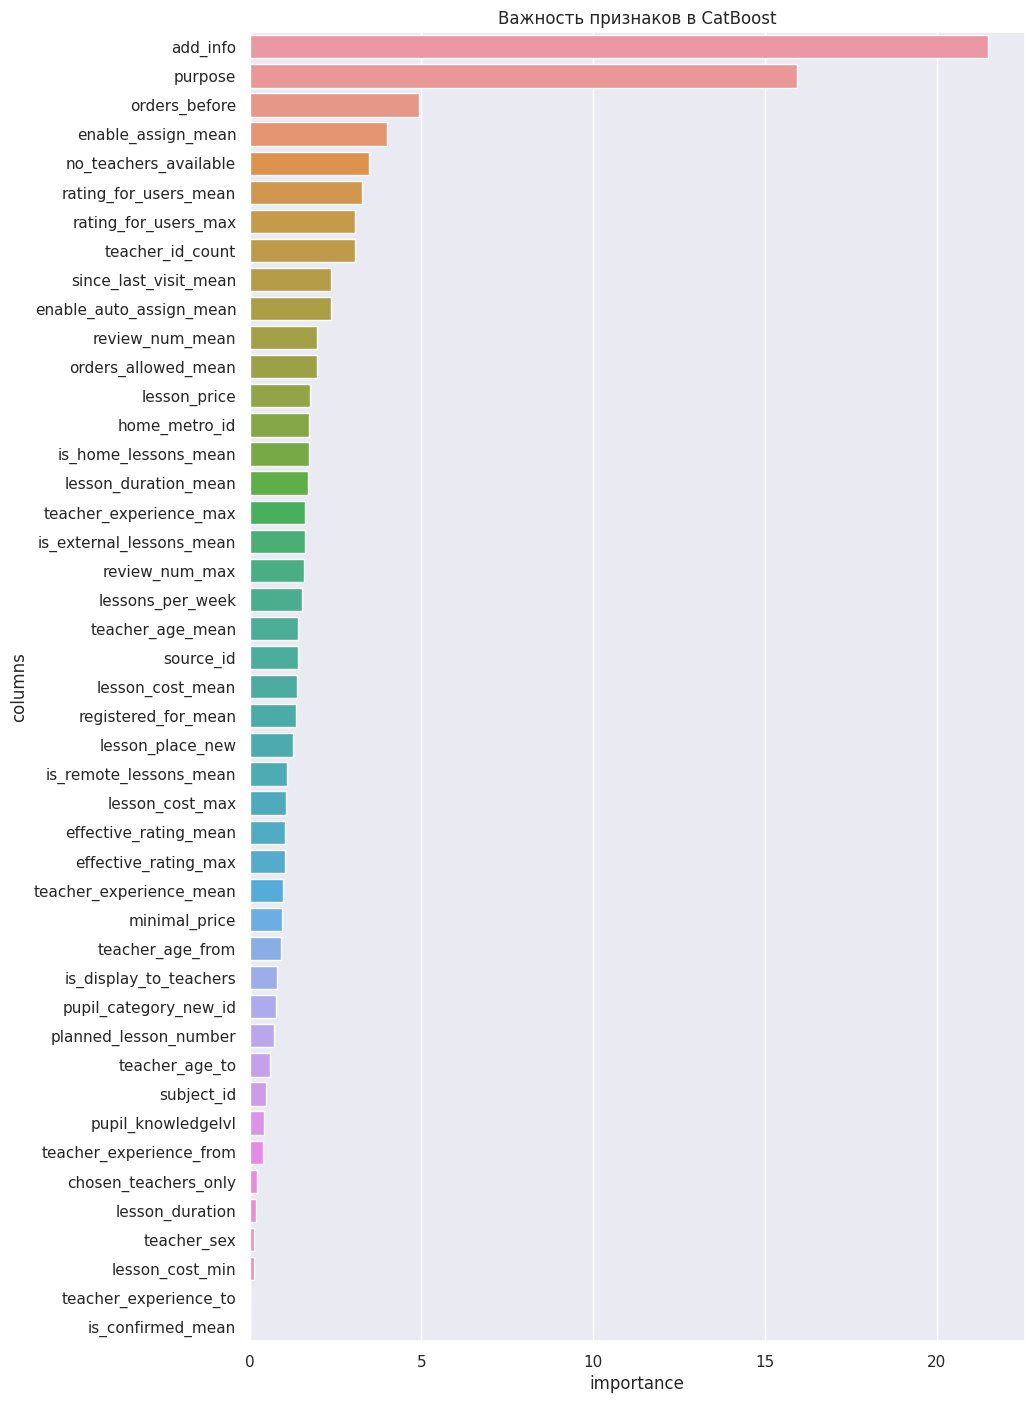

In [ ]:
sns.set(rc={'figure.figsize':(10, 17)})
feat_importance = pd.DataFrame({'columns': X_train.columns, 'importance': cb.get_feature_importance()})
feat_importance.sort_values(by='importance', ascending=False, inplace=True)
sns.barplot(y=feat_importance['columns'], x=feat_importance['importance'])
plt.title('Важность признаков в CatBoost');

## Тест

In [ ]:
pred_proba = cb.predict_proba(X_test)
pred = cb.predict(X_test)

In [ ]:
print(f'ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred_proba[:, 1]):.4f}')
print(f'F1 на тестовой выборке: {f1_score(y_test, pred):.4f}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, pred):.4f}')
print(f'Precision на тестовой выборке: {precision_score(y_test, pred):.4f}')
print(f'Recall на тестовой выборке: {recall_score(y_test, pred):.4f}')

ROC-AUC на тестовой выборке: 0.7331
F1 на тестовой выборке: 0.4398
Accuracy на тестовой выборке: 0.6821
Precision на тестовой выборке: 0.3346
Recall на тестовой выборке: 0.6416


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.69      0.78    134277
           1       0.33      0.64      0.44     32428

    accuracy                           0.68    166705
   macro avg       0.61      0.67      0.61    166705
weighted avg       0.78      0.68      0.71    166705



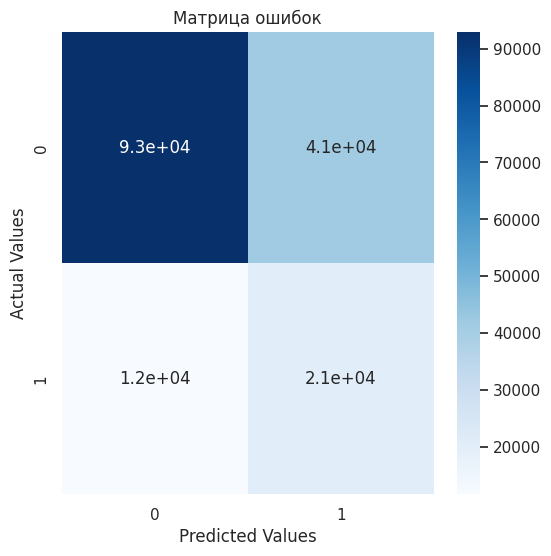

In [ ]:
cf_matrix = confusion_matrix(y_test, pred)
sns.set(rc={'figure.figsize':(6, 6)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Матрица ошибок');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');